In [31]:
#!pip install datasets
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 19.8 MB/s eta 0:00:00


In [32]:
# import datasets
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from typing import Callable, Iterable
from app.dataset.homer_dataset import HomerDataset
from app.biencoder.sentence_bert import SentenceBert, encode, mini_batch, get_train_step_fn, get_val_step_fn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cpu


In [4]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Crate dataset

In [5]:
# Загрузим данные из источника и поготовим токенизатор
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
raw_df = pd.read_csv('data/simpsons_dataset.csv')
raw_df.head(10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [6]:
%%time
# Инициализируем датасет
homer_dataset = HomerDataset(raw_df, tokenizer)

CPU times: user 58.3 s, sys: 8.75 s, total: 1min 7s
Wall time: 1min 5s


In [7]:
len(homer_dataset)

124681

In [8]:
# Разобьём датасет на трейн и тест
train_ratio = 0.8
n_total = len(homer_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(homer_dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# BI-Encoder

In [18]:
model = SentenceBert(device=device)
model_location = "app/model/sentence_bert_biencoder" #"/content/drive/MyDrive/models/sentence_bert_softmax_lr_2e-6"

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, device=device)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False, device=device)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)

In [ ]:
model.bert_model.save_pretrained(model_location)

In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

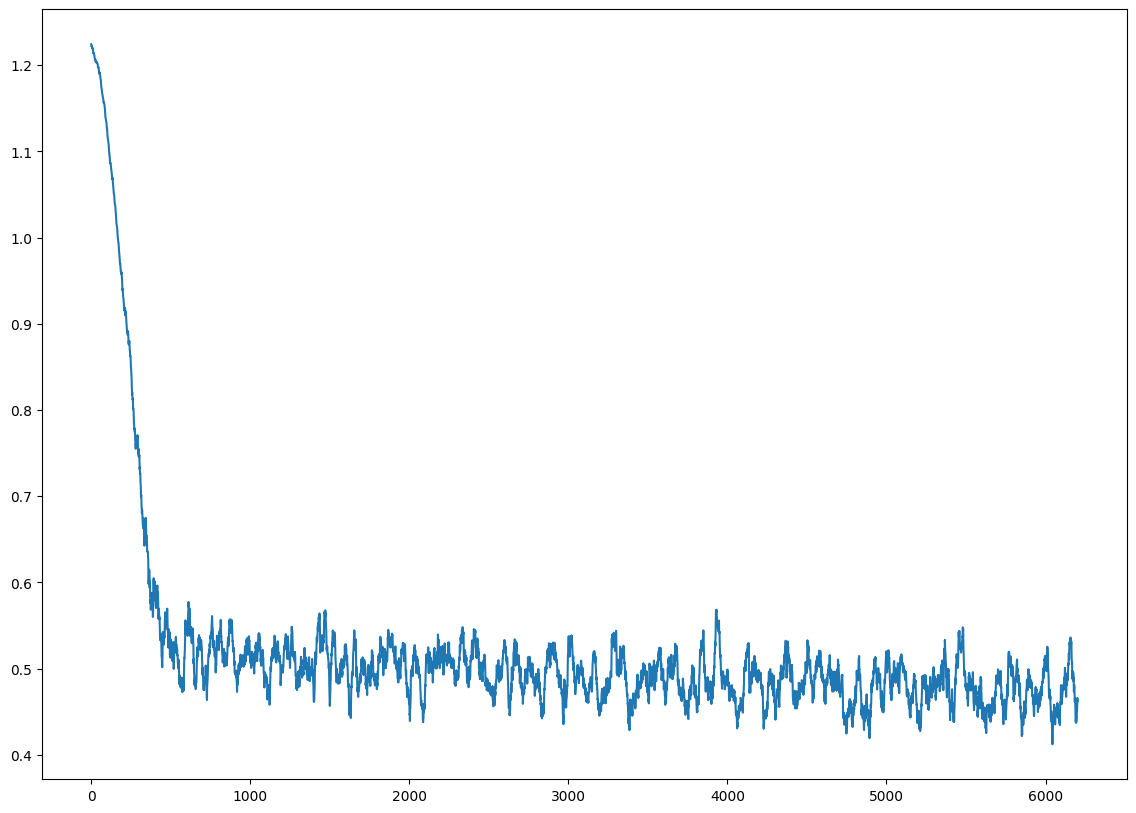

In [ ]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [19]:
model.bert_model = model.bert_model.from_pretrained(model_location)

In [20]:
sentences = [
    'Hello, Homer',
    "Hi!",
    "Were is Lisa?",
    "She should be at school",
    "Your house is on fire",
    "Woo hoo",
    "What is your name?",
    "I am Homer"
]

In [23]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

In [22]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

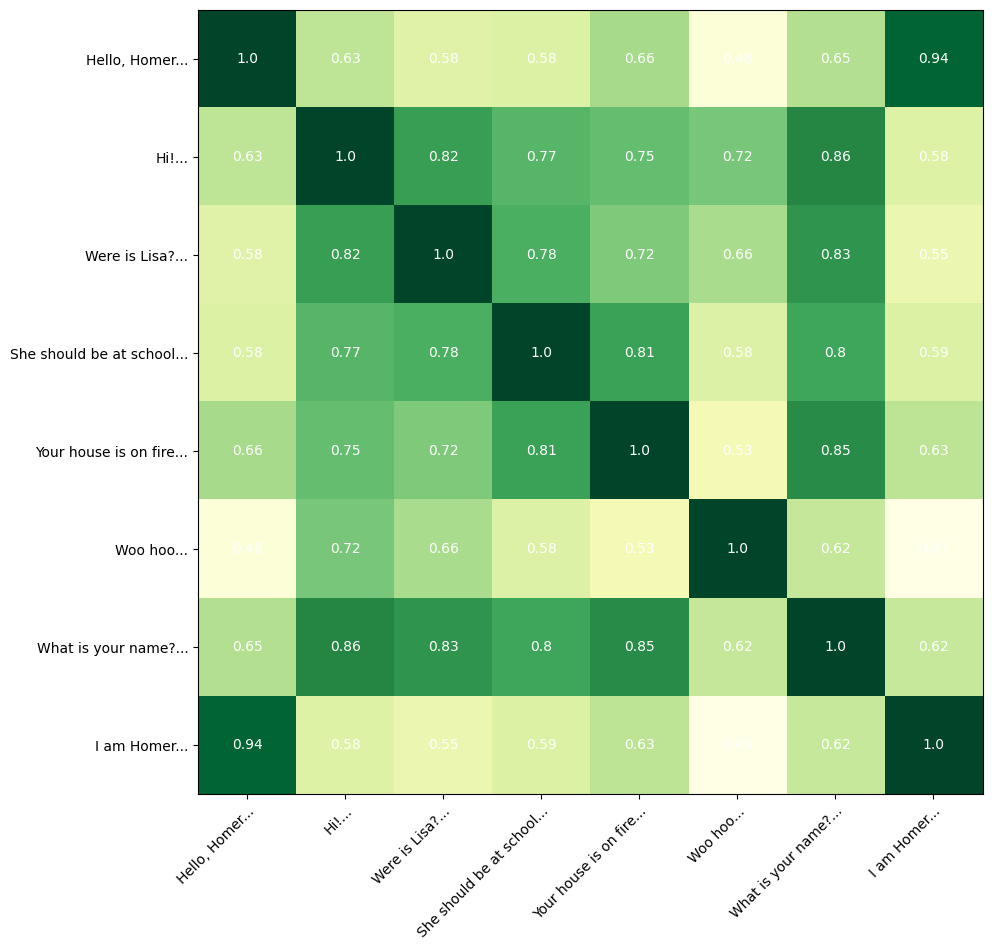

In [25]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

# Faiss to find response-candidates

In [27]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('hello, Homer', model.bert_model, model.bert_tokenizer).shape)

(768,)


In [ ]:
# base = np.array([embed_bert_cls('UNK' if not isinstance(phrase, str) else phrase, model.bert_model, model.bert_tokenizer) for phrase in tqdm(set(data['spoken_words']))])
# np.save('/content/drive/MyDrive/models/base.npy', base)

  0%|          | 0/121760 [00:00<?, ?it/s]

In [ ]:
#base = np.load('/content/drive/MyDrive/models/base.npy')

In [81]:
homer_phrases = raw_df[(~raw_df['spoken_words'].isna()) & (raw_df['raw_character_text']=='Homer Simpson')]
homer_phrases_list = list()
for ph in homer_phrases['spoken_words'].str.split('[.?!]').tolist():
     homer_phrases_list.extend(ph)
homer_phrases = list(set(homer_phrases_list))
homer_base = np.array([embed_bert_cls('UNK' if len(phrase)<2 or not isinstance(phrase, str)  else phrase, model.bert_model, model.bert_tokenizer) for phrase in tqdm(homer_phrases)])

  0%|          | 0/40539 [00:00<?, ?it/s]

In [82]:
np.save('app/model/homer_base.npy', homer_base)

In [83]:
#index = faiss.IndexFlatL2(base.shape[1])
index = faiss.IndexFlatL2(homer_base.shape[1])

In [84]:
#index.add(base)
index.add(homer_base)

In [113]:
k = 4
query = 'Woo Hoo'
# xq = embed_bert_cls(query, model.bert_model, model.bert_tokenizer)
# xq.shape
pooled_embeds = encode(query, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

In [114]:
%%time
# D, I = index.search(xq.reshape(1, 768), 6)  # search
D, I = index.search(pooled_embeds, 10)
print(I)

[[  328  3243 33417 34479   510  8020 34185  5919 10820 20781]]
CPU times: user 20.6 ms, sys: 0 ns, total: 20.6 ms
Wall time: 22.8 ms


In [115]:
candidates = [homer_phrases[i] for i in I[0]]
for candidate in candidates:
  print(candidate)

 Woo hoo
Woo Hoo
Woo hoo
 Woo hoo hoo
Woo hoo, hoo
Woo hoo hoo hoo
 Woo hoo hoo hoo
 Woo-hoo
Woo-hoo
Woo-Hoo


# Cross-Encoder to rerank candidates

In [ ]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["prompt"] for data in dataset],
                            [data["response"] for data in dataset],
                            max_length=MAX_LENGTH,
                            padding="max_length",
                            truncation=True,
                            verbose=True)

CPU times: user 24.2 s, sys: 2.2 s, total: 26.4 s
Wall time: 20.4 s


In [ ]:
class CEDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [ ]:
%%time

ce_dataset = CEDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 12.3 ms


In [ ]:
train_ratio = 0.8
n_total = len(ce_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(ce_dataset, [n_train, n_val]) # рандом, потому что данные можно перемешать, не потеряв суть

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(6234, 1559)

In [ ]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1) # Предсказывать будет метку: оценка от 1 до 5

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        # (seq_len, bert_dim)
        pooled_output = outputs.last_hidden_state[:,0] # Use the CLS token`s output (в нем весь текст)
        return self.linear(pooled_output)

In [ ]:
def test_cross_encoder_bert():
    max_length = 128
    model = CrossEncoderBert(max_length=max_length)

    # Check __init__ method
    assert model.max_length == max_length, "Incorrect max_length initialization"
    assert isinstance(model.linear, torch.nn.Linear), "linear is not an instance of torch.nn.Linear"
    assert model.linear.in_features == model.bert_model.config.hidden_size, "Incorrect input size for linear layer"

    # Prepare dummy data for forward method check
    input_text = ["Hello, world!"]
    inputs = model.bert_tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Check forward method
    output = model(input_ids, attention_mask)
    assert output.shape == (1, 1), "Output shape is incorrect"

    print("All checks passed!")

test_cross_encoder_bert()

All checks passed!


In [ ]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss() # Можно перейти к кросс-энтропии, но тогда нужно преобразовывать лейблы вначале

In [ ]:
ce_model = CrossEncoderBert().to(device)

In [ ]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(ce_model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(ce_model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
%%time

n_epochs = 2 # Модель быстро начинает переобучаться

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/6234, Loss = 0.583
Step    64/6234, Loss = 0.352
Step   128/6234, Loss = 0.372
Step   192/6234, Loss = 0.702
Step   256/6234, Loss = 0.290
Step   320/6234, Loss = 0.399
Step   384/6234, Loss = 0.547
Step   448/6234, Loss = 0.502
Step   512/6234, Loss = 0.186
Step   576/6234, Loss = 0.279
Step   640/6234, Loss = 0.271
Step   704/6234, Loss = 0.541
Step   768/6234, Loss = 0.493
Step   832/6234, Loss = 0.352
Step   896/6234, Loss = 0.466
Step   960/6234, Loss = 0.510
Step  1024/6234, Loss = 0.202
Step  1088/6234, Loss = 0.339
Step  1152/6234, Loss = 0.513
Step  1216/6234, Loss = 0.560
Step  1280/6234, Loss = 0.348
Step  1344/6234, Loss = 0.595
Step  1408/6234, Loss = 0.687
Step  1472/6234, Loss = 0.348
Step  1536/6234, Loss = 0.543
Step  1600/6234, Loss = 0.272
Step  1664/6234, Loss = 0.613
Step  1728/6234, Loss = 0.381
Step  1792/6234, Loss = 0.345
Step  1856/6234, Loss = 0.434
Step  1920/6234, Loss = 0.377
Step  1984/6234, Loss = 0.425
Step  2048/6234, Loss = 0.153
S

In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

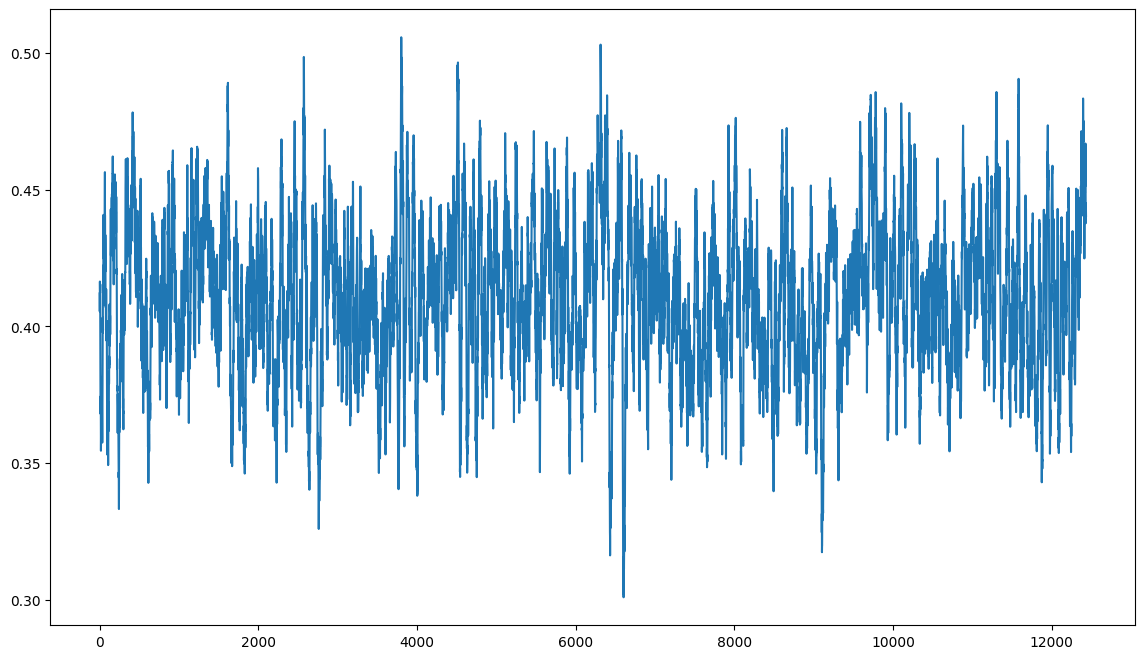

In [ ]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [ ]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [ ]:
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

In [ ]:
get_ranked_docs(tokenizer, ce_model, bert_model.to(device), query, candidates)

Query - Where is Bart [Finetuned Cross-Encoder]
---
0.47	TWO PLUS TWO IS FOUR / TWO PLUS TWO IS FOUR.... / TWO PLUS TWO IS FOUR....
0.46	WELL\WELL\WELL...W-W-W-WELL\WELL\WELL...
0.45	Well, the standard form is under, over, under, over, under, under, under, under, under, over, over, under, under, under, around, over, over, under...
0.43	The sum of the square roots of any two sides of an isosceles triangle is equal to the square root of the remaining side.
0.43	The sum of the square roots of any two sides of an isosceles triangle is equal to the square root of the remaining sides.
0.43	Fractions aren't that hard, you just have to find a common denominator. For example: one half plus one third equals...
0.42	Be be be be be.
0.42	And the number e. Not the letter e, but the number whose exponential function is the derivative of itself.
0.42	...assuming a linear growth model...
0.42	Here, the solution is a square.

Query - Where is Bart [Bert Base]
---
0.47	TWO PLUS TWO IS FOUR / TWO PLUS TW

In [ ]:
ce_model.bert_model.save_pretrained("/content/drive/MyDrive/models/ce_bert")